## multiclass classifier on binned labeling, imbalanced classes

11 bins lead to 11 labels

tree classifier used on binned labels (variant)

imbalanced classes in data

## classifier method search

premise: use a looped grid search to explore the accuracy metrics of classfiers

In [1]:
!pip3 install shap



Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
# import category_encoders as ce
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, RandomTreesEmbedding, BaggingClassifier
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
import shap
import pandas as pd
import time
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
m2_pipeline = pd.read_csv('../0 Data Processing/binned_pipeline.csv')


In [4]:
m2_pipeline.columns

Index(['group', 'time', 's_MP', 'change', 'type', 'p_MP',
       'precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change',
       'precursor_bid_vol_pct_change', 'precursor_ask_vol_pct_change',
       'length', 'sum_change', 'max_surge_mp', 'min_surge_mp',
       'max_precursor_mp', 'min_precursor_mp', 'area', 'surge_targets_met_pct',
       'group.1', 'time.1', 's_MP.1', 'change.1', 'type.1', 'p_MP.1',
       'precursor_buy_cap_pct_change.1', 'precursor_ask_cap_pct_change.1',
       'precursor_bid_vol_pct_change.1', 'precursor_ask_vol_pct_change.1',
       'length.1', 'sum_change.1', 'max_surge_mp.1', 'min_surge_mp.1',
       'max_precursor_mp.1', 'min_precursor_mp.1', 'area.1', 'surge_area',
       'surge_targets_met_pct.1', 'label'],
      dtype='object')

In [5]:
corr_list = [
       'precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change',
       'precursor_bid_vol_pct_change', 'precursor_ask_vol_pct_change','length', 'sum_change', 'surge_targets_met_pct','time', 'label']

m2_pipeline = m2_pipeline[corr_list]

## testing data for colinearity among features

In [6]:
m2_pipeline.corr(numeric_only=True)

,precursor_buy_cap_pct_change,precursor_ask_cap_pct_change,precursor_bid_vol_pct_change,precursor_ask_vol_pct_change,length,sum_change,surge_targets_met_pct,time,label
precursor_buy_cap_pct_change,1.000000,0.218251,0.825875,0.082502,-0.047718,0.129882,0.007553,-0.078689,-0.001345
precursor_ask_cap_pct_change,0.218251,1.000000,0.340009,0.092719,0.021504,-0.092942,-0.020821,-0.035844,-0.024504
precursor_bid_vol_pct_change,0.825875,0.340009,1.000000,0.011741,-0.025773,-0.006089,0.005475,-0.078782,-0.003535
precursor_ask_vol_pct_change,0.082502,0.092719,0.011741,1.000000,0.070062,-0.053649,0.020034,0.016948,0.018670
length,-0.047718,0.021504,-0.025773,0.070062,1.000000,-0.184258,0.070419,0.062394,0.041270
sum_change,0.129882,-0.092942,-0.006089,-0.053649,-0.184258,1.000000,-0.024879,0.010110,-0.055740
surge_targets_met_pct,0.007553,-0.020821,0.005475,0.020034,0.070419,-0.024879,1.000000,-0.001294,0.894719
time,-0.078689,-0.035844,-0.078782,0.016948,0.062394,0.010110,-0.001294,1.000000,-0.022661
label,-0.001345,-0.024504,-0.003535,0.018670,0.041270,-0.055740,0.894719,-0.022661,1.000000


<Axes: >

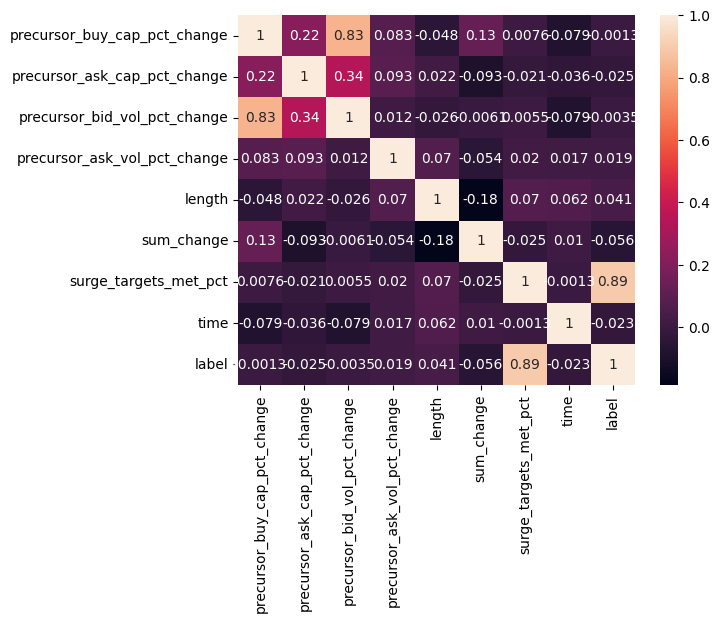

In [7]:
import pandas as pd
import seaborn as sns

# Load the dataset into a pandas dataframe

# Calculate the correlation matrix
corr_matrix = m2_pipeline.corr(numeric_only=True)

# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True)


In [8]:
m2_pipeline.dtypes

precursor_buy_cap_pct_change    float64
precursor_ask_cap_pct_change    float64
precursor_bid_vol_pct_change    float64
precursor_ask_vol_pct_change    float64
length                            int64
sum_change                      float64
surge_targets_met_pct           float64
time                            float64
label                             int64
dtype: object

### utilize the same feature composition as used in step 2

clustering setup, per 'step 2'

set m2_pipeline features to the set, below to do a classifier search

In [9]:
keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change','length','time']

In [10]:

# Splitting the dataframe into features and labels
# X = m2_pipeline.drop(columns=['label'])
y = m2_pipeline['label'].values #per https://stackoverflow.com/a/73095562/12001832
X = m2_pipeline[keepable].values
# Performing the test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize all numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.fit_transform(X_test)
# Define the classifiers and their respective hyperparameters
classifiers = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    HistGradientBoostingClassifier(),
    ExtraTreesClassifier(),
    BaggingClassifier(),
    RidgeCV(),
    LassoCV(),
    SVC()
]

params = {
    'RandomForestClassifier': {'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'GradientBoostingClassifier': {'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'HistGradientBoostingClassifier': {'learning_rate': [0.1, 0.01], 'max_iter': [100, 200]},
    'ExtraTreesClassifier':{'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'BaggingClassifier':{ 'n_estimators':[10],  'random_state':[42]},
    'RidgeCV':{'alphas':[0.1, 1.0, 10.0]},
    'LassoCV':{ 'eps':[0.001, 0.01, .1], 'n_alphas':[100,200],  'max_iter':[100,200,300,1000]},
    'SVC':{'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
}
comparative = []
# Perform the grid search
for clf in classifiers:
    name = clf.__class__.__name__
    if name in params:
        grid_search = GridSearchCV(clf, params[name], cv=5)
        grid_search.fit(X_train_scaled, y_train)
        
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        accuracy = grid_search.score(X_test_scaled, y_test)
        
        dict = {"classifier":name, "best_params":grid_search.best_params_, "accuracy":accuracy}
        comparative.append(dict)
dg = pd.DataFrame(comparative) #display grid

The least populated class in y has only 4 members, which is less than n_splits=5.


Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 1000}


The least populated class in y has only 4 members, which is less than n_splits=5.


Best parameters for GradientBoostingClassifier: {'max_depth': 10, 'n_estimators': 100}


The least populated class in y has only 4 members, which is less than n_splits=5.


Best parameters for HistGradientBoostingClassifier: {'learning_rate': 0.01, 'max_iter': 100}


The least populated class in y has only 4 members, which is less than n_splits=5.


Best parameters for ExtraTreesClassifier: {'max_depth': 10, 'n_estimators': 1000}


The least populated class in y has only 4 members, which is less than n_splits=5.


Best parameters for BaggingClassifier: {'n_estimators': 10, 'random_state': 42}
Best parameters for RidgeCV: {'alphas': 10.0}
Best parameters for LassoCV: {'eps': 0.01, 'max_iter': 100, 'n_alphas': 100}


The least populated class in y has only 4 members, which is less than n_splits=5.


Best parameters for SVC: {'C': 1, 'kernel': 'rbf'}


In [11]:
dg

,classifier,best_params,accuracy
0,RandomForestClassifier,"{'max_depth': 10, 'n_estimators': 1000}",0.430192
1,GradientBoostingClassifier,"{'max_depth': 10, 'n_estimators': 100}",0.352531
2,HistGradientBoostingClassifier,"{'learning_rate': 0.01, 'max_iter': 100}",0.433682
3,ExtraTreesClassifier,"{'max_depth': 10, 'n_estimators': 1000}",0.433682
4,BaggingClassifier,"{'n_estimators': 10, 'random_state': 42}",0.343805
5,RidgeCV,{'alphas': 10.0},0.003900
6,LassoCV,"{'eps': 0.01, 'max_iter': 100, 'n_alphas': 100}",0.004016
7,SVC,"{'C': 1, 'kernel': 'rbf'}",0.433682


In [12]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=1000,random_state= 42)
gbc = GradientBoostingClassifier(max_depth= 10, n_estimators= 100,random_state= 42)
hgbc = HistGradientBoostingClassifier(learning_rate= 0.01, max_iter= 100,random_state= 42)
etc = ExtraTreesClassifier(max_depth= 10, n_estimators= 1000,random_state= 42)
bc = BaggingClassifier(n_estimators= 10, random_state= 42)
svc = SVC(C=1, kernel='rbf')
treeGroup = [rfc, etc, gbc, hgbc] #tree based classifiers, for feature importance

## Voting Classifier

In [13]:
import shap #this library would take 30 hours to explain the above model, not to be used. would function on one tree, better
from sklearn.ensemble import  VotingClassifier 
from sklearn.model_selection import cross_val_score
X = m2_pipeline[keepable].values  #.drop(columns=['label']).values #per https://stackoverflow.com/a/73095562/12001832
y = m2_pipeline['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize all numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Define VotingClassifier 
weights = [0.1, 0.5, 0.1, 0.1, 0.2]
vc = VotingClassifier(estimators=[('rfc',rfc),('gbc',gbc),('hgbc',hgbc),('etc',etc),('bc',bc)], voting='hard', weights=weights) 
rfc.fit(X_train_scaled,y_train)
gbc.fit(X_train_scaled,y_train)
hgbc.fit(X_train_scaled,y_train)
etc.fit(X_train_scaled,y_train)
bc.fit(X_train_scaled,y_train)
svc.fit(X_train_scaled,y_train)
vc.fit(X_train_scaled,y_train)

# #fit all, voting classifier scoring
for clf, label in zip([rfc,gbc,hgbc,etc,bc,svc,vc], ['RandomForestClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'ExtraTreesClassifier',\
                                                    'BaggingClassifier','SVC','Voting']):
    scores = cross_val_score(clf, X_test_scaled, y_test, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

The least populated class in y has only 3 members, which is less than n_splits=5.


Accuracy: 0.42 (+/- 0.01) [RandomForestClassifier]


The least populated class in y has only 3 members, which is less than n_splits=5.


Accuracy: 0.37 (+/- 0.02) [GradientBoostingClassifier]


The least populated class in y has only 3 members, which is less than n_splits=5.


Accuracy: 0.40 (+/- 0.01) [HistGradientBoostingClassifier]


The least populated class in y has only 3 members, which is less than n_splits=5.


Accuracy: 0.43 (+/- 0.01) [ExtraTreesClassifier]
Accuracy: 0.37 (+/- 0.01) [BaggingClassifier]


The least populated class in y has only 3 members, which is less than n_splits=5.
The least populated class in y has only 3 members, which is less than n_splits=5.


Accuracy: 0.44 (+/- 0.00) [SVC]


The least populated class in y has only 3 members, which is less than n_splits=5.


Accuracy: 0.39 (+/- 0.02) [Voting]


### feature importance based on feature permutation
[via scikit learn's rendition](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-feature-permutation)

Index(['precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change',
       'precursor_bid_vol_pct_change', 'precursor_ask_vol_pct_change',
       'length', 'sum_change', 'surge_targets_met_pct', 'time', 'label'],
      dtype='object') 7
RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=42)
Elapsed time to compute the importances: 6.631 seconds
RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=42)


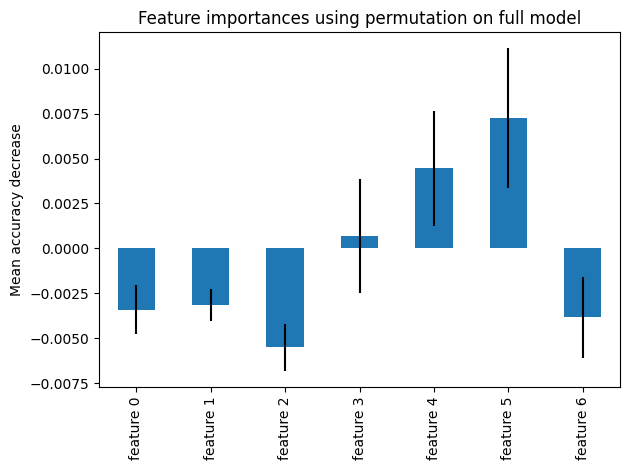

ExtraTreesClassifier(max_depth=10, n_estimators=1000, random_state=42)
Elapsed time to compute the importances: 4.051 seconds
ExtraTreesClassifier(max_depth=10, n_estimators=1000, random_state=42)


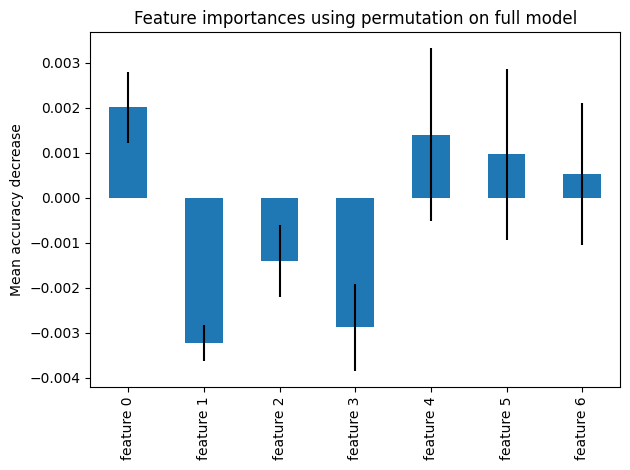

GradientBoostingClassifier(max_depth=10, random_state=42)
Elapsed time to compute the importances: 2.366 seconds
GradientBoostingClassifier(max_depth=10, random_state=42)


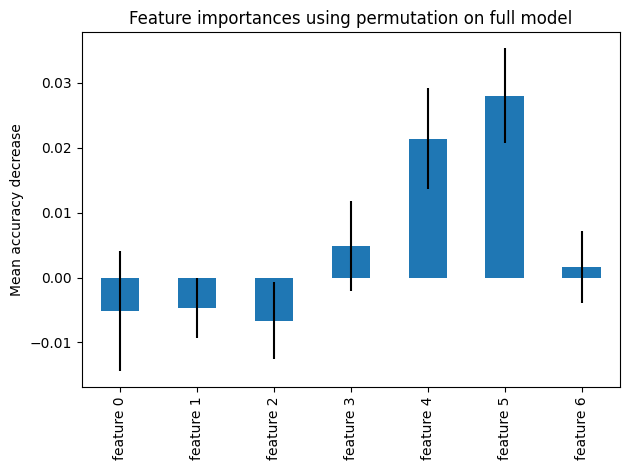

HistGradientBoostingClassifier(learning_rate=0.01, random_state=42)
Elapsed time to compute the importances: 2.904 seconds
HistGradientBoostingClassifier(learning_rate=0.01, random_state=42)


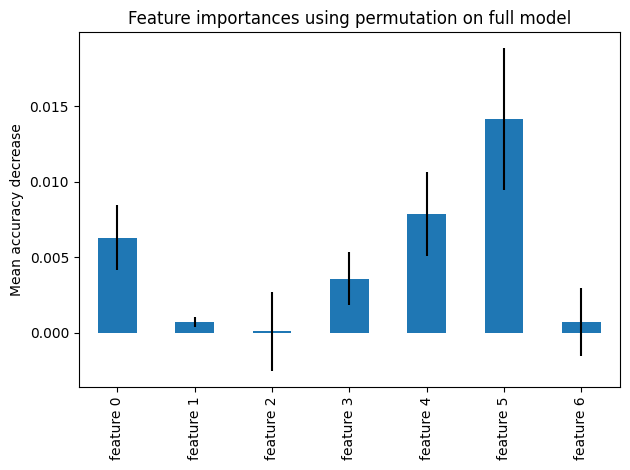

In [14]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]

print(m2_pipeline.columns,X.shape[1])
for i in range(len(treeGroup)):
    print(treeGroup[i]) #tree to study
    forest = treeGroup[i]
    start_time = time.time()
    result = permutation_importance(forest, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=2)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

    forest_importances = pd.Series(result.importances_mean, index=feature_names)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    print(treeGroup[i]) #tree to study

    plt.show()

## Error Analysis

confusion matrix for multiclass predict vs true results. [source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html)

In [15]:
labels_ = m2_pipeline['label'].unique()
print(labels_)

[ 4  5  6  8  3  7 10  2  9 11  1]


## voting classifier error analysis

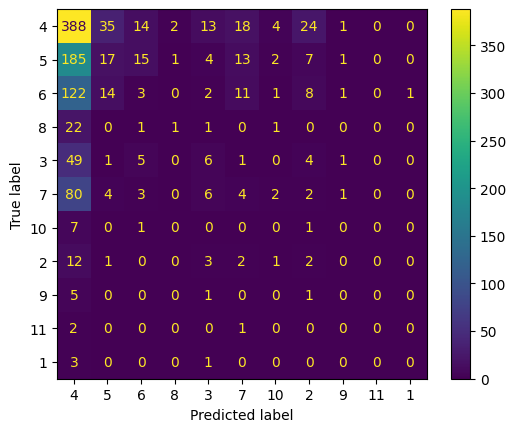

In [16]:
X_test_scaled = scaler.fit_transform(X_test)
y_pred = vc.predict(X_test_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=labels_)

error report courtesty of sklearn's [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn-metrics-classification-report)

In [17]:
print(classification_report(y_test, y_pred,zero_division=1))

              precision    recall  f1-score   support

           1       0.00      0.00      1.00         4
           2       0.04      0.10      0.06        21
           3       0.16      0.09      0.12        67
           4       0.44      0.78      0.56       499
           5       0.24      0.07      0.11       245
           6       0.07      0.02      0.03       163
           7       0.08      0.04      0.05       102
           8       0.25      0.04      0.07        26
           9       0.00      0.00      1.00         7
          10       0.00      0.00      1.00         9
          11       1.00      0.00      0.00         3

    accuracy                           0.37      1146
   macro avg       0.21      0.10      0.36      1146
weighted avg       0.28      0.37      0.30      1146



uncertainty in prediction, per class basis, [per sklearn](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits.html#plot-the-most-uncertain-predictions)

## SHAP feature analysis

[source](https://github.com/shap/shap)

In [19]:
keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change',
            'length','time']

### Random Forest Classifier Feature Strength

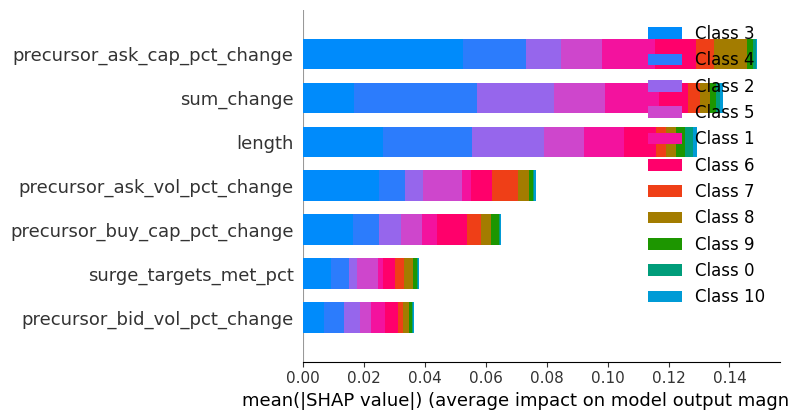

In [20]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = rfc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

### HGBC SHAP

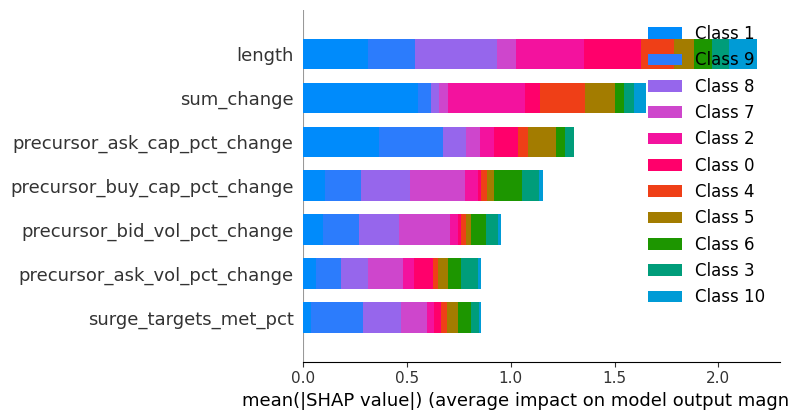

In [21]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = hgbc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

### Extra Trees Classifier SHAP

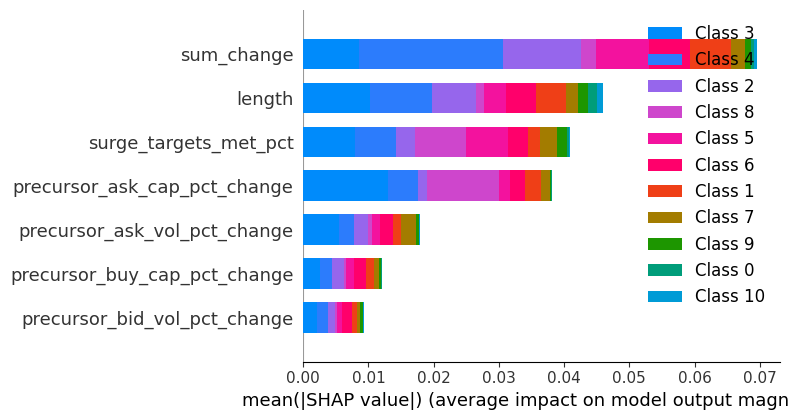

In [22]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = etc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

## 


### How do multiple classifiers collectively make good choices?

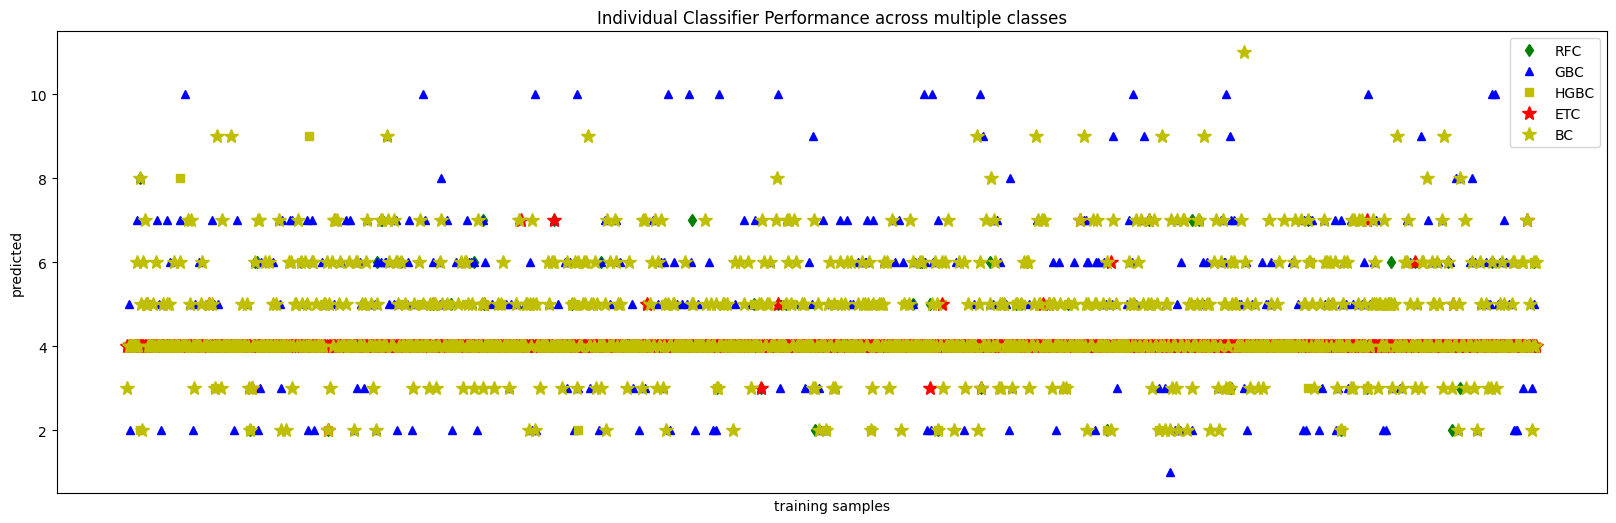

In [23]:
xt = X_test_scaled#  train_scaled[:300]

pred1 = rfc.predict(xt)
pred2 = gbc.predict(xt)
pred3 = hgbc.predict(xt)

pred4 = etc.predict(xt)
pred5 = bc.predict(xt)
pred6 = vc.predict(xt)

plt.figure(figsize=(20,6))
plt.plot(pred1, "gd", label="RFC")
plt.plot(pred2, "b^", label="GBC")
plt.plot(pred3, "ys", label="HGBC")
plt.plot(pred4, "r*", ms=10, label="ETC")
plt.plot(pred5, "y*", ms=10, label="BC")
# plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Individual Classifier Performance across multiple classes")
# ax.annotate('race interrupted', (61, 25),
#             xytext=(0.8, 0.9), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             fontsize=16,
#             horizontalalignment='right', verticalalignment='top')
plt.show()


### Can the voting classifier locate optimal trades among a sea of lesser options?

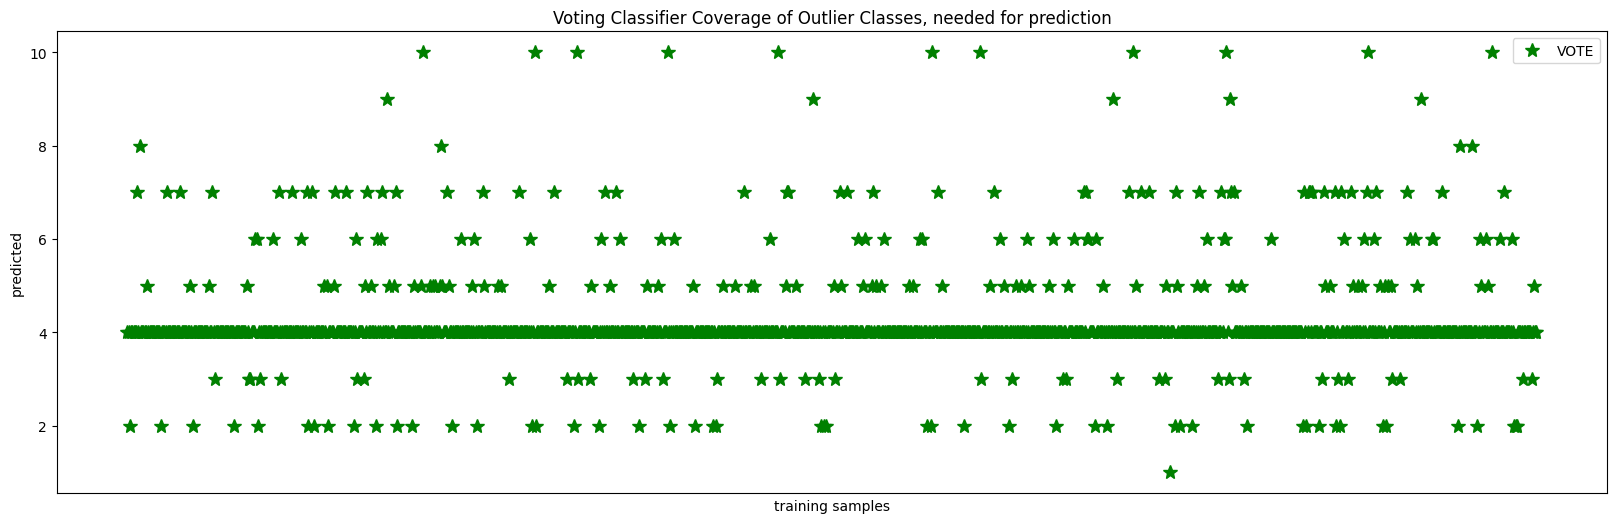

In [24]:
plt.figure(figsize=(20,6))
plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Voting Classifier Coverage of Outlier Classes, needed for prediction")
plt.show()

### GBC ability to identify outlier, profitable classes

              precision    recall  f1-score   support

           1       0.00      0.00      1.00         4
           2       0.04      0.10      0.06        21
           3       0.16      0.09      0.12        67
           4       0.45      0.67      0.54       499
           5       0.28      0.14      0.19       245
           6       0.11      0.06      0.08       163
           7       0.09      0.06      0.07       102
           8       0.17      0.04      0.06        26
           9       0.00      0.00      1.00         7
          10       0.00      0.00      1.00         9
          11       1.00      0.00      0.00         3

    accuracy                           0.34      1146
   macro avg       0.21      0.11      0.37      1146
weighted avg       0.29      0.34      0.32      1146



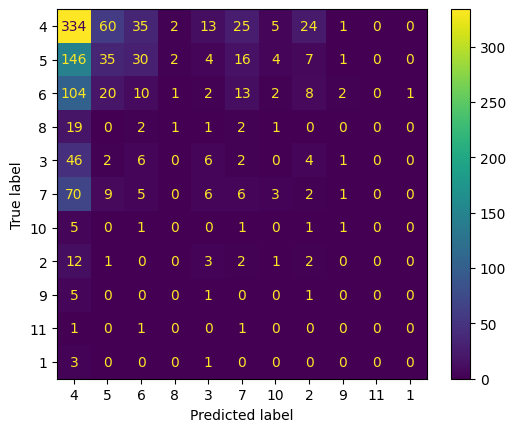

In [25]:
# X_test_scaled = scaler.fit_transform(X_test)
y_pred_gbc = gbc.predict(X_test_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gbc, labels=labels_)

print(classification_report(y_test, y_pred_gbc,zero_division=1))


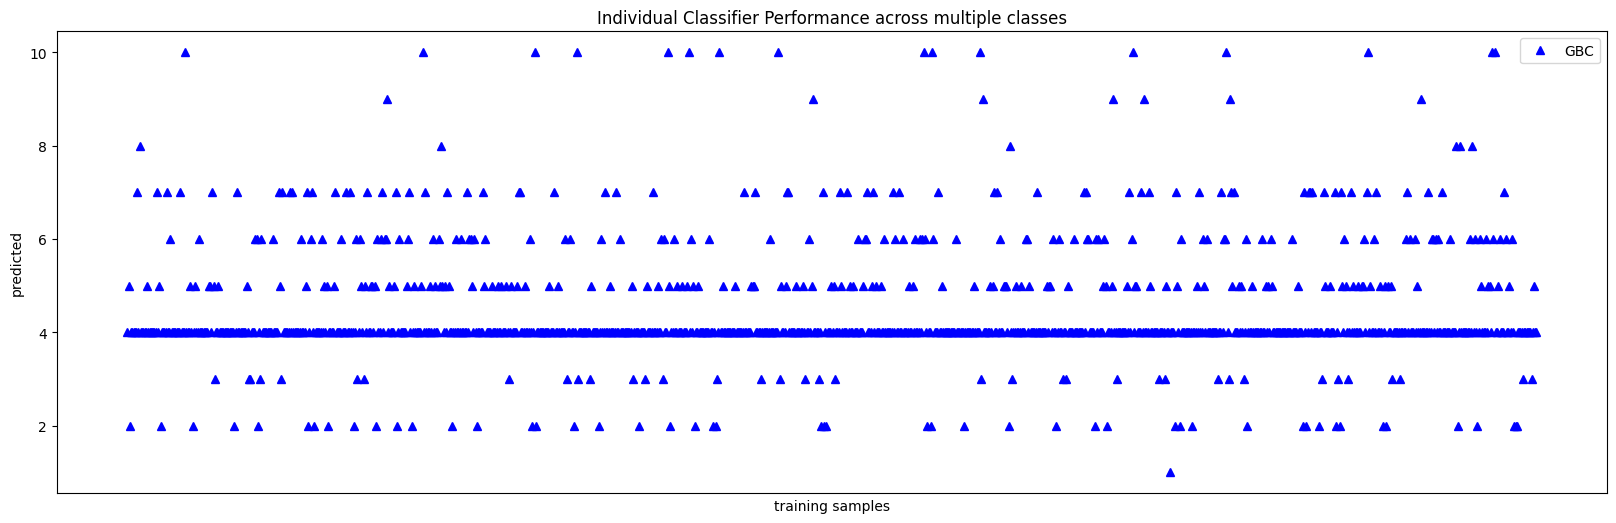

In [26]:
plt.figure(figsize=(20,6))
plt.plot(pred2, "b^", label="GBC")

# plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Individual Classifier Performance across multiple classes")
plt.show()


## create a time series from predicted values

In [157]:



# Predict labels for your test data
y_pred = gbc.predict(X_test_scaled)

X_test_df = pd.DataFrame(X_test_scaled)

# Concatenate the predicted labels with X_test_df
result = pd.concat([X_test_df, pd.Series(y_pred, name='predicted_label')], axis=1)

In [190]:
result['predicted_label'].value_counts()

4     917
5     147
7      60
6      18
9      16
8       6
11      1
3       1
Name: predicted_label, dtype: int64

In [171]:
print('\n'.join([f'{i}: {value}' for i, value in enumerate(keepable)]))

0: precursor_buy_cap_pct_change
1: precursor_ask_cap_pct_change
2: precursor_bid_vol_pct_change
3: precursor_ask_vol_pct_change
4: sum_change
5: length
6: time


In [173]:
result.dtypes

0                  float64
1                  float64
2                  float64
3                  float64
4                  float64
5                  float64
6                  float64
predicted_label      int64
dtype: object

In [177]:
# sns.pairplot(result, hue='predicted_label', height=1.5)
result = result.sort_values(by=6)

In [195]:
keepable = ['precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 'precursor_ask_vol_pct_change',
            'sum_change', 'length', 'time','predicted_label']

result = result.rename(columns={i: keepable[i] for i in range(7)})

In [197]:
result

,precursor_buy_cap_pct_change,precursor_ask_cap_pct_change,precursor_bid_vol_pct_change,precursor_ask_vol_pct_change,sum_change,length,surge_targets_met_pct,predicted_label
332,-0.008301,0.000101,-0.001793,0.015760,-0.008805,3.0,1.660232e+12,4
1093,0.251821,0.002041,0.076246,0.360129,-0.002041,1.0,1.660249e+12,7
234,-0.072644,0.000178,-0.022135,0.032534,-0.022106,4.0,1.660257e+12,4
301,0.066227,0.001243,0.022618,0.185320,-0.000311,1.0,1.660269e+12,7
952,-0.196120,-0.002084,-0.067795,-0.263773,-0.005565,2.0,1.660284e+12,6
...,...,...,...,...,...,...,...,...
1130,0.004096,0.000166,0.000969,0.000788,-0.000501,1.0,1.692974e+12,4
405,-0.003737,0.003281,-0.000869,0.016512,-0.005082,5.0,1.692990e+12,4
828,0.000449,-0.000605,0.000022,-0.003029,-0.000696,1.0,1.693045e+12,4
76,-0.008630,-0.000898,-0.002323,-0.003895,-0.001692,2.0,1.693064e+12,4


In [198]:
gds = pd.read_csv('global_data.csv')

In [199]:
# make a dataframe by joining gds on result, by time

# chart mp to time as a line  


# chart vertical lines for time and predicted_label


## why does GBC confuse class 10 as class 4?

In [77]:
m2_pipeline.columns

Index(['Unnamed: 0', 'precursor_buy_cap_pct_change',
       'precursor_ask_cap_pct_change', 'precursor_bid_vol_pct_change',
       'precursor_ask_vol_pct_change', 'sum_change', 'length',
       'surge_targets_met_pct', 'label'],
      dtype='object')

In [78]:
m2_pipeline.dtypes

Unnamed: 0                        int64
precursor_buy_cap_pct_change    float64
precursor_ask_cap_pct_change    float64
precursor_bid_vol_pct_change    float64
precursor_ask_vol_pct_change    float64
sum_change                      float64
length                            int64
surge_targets_met_pct           float64
label                             int64
dtype: object

In [87]:
# m2_pipeline[m2_pipeline['label'] == 4]

In [23]:
# Select rows with label equal to 4 or 10
# rows = m2_pipeline[(m2_pipeline['label'] == 4) | (m2_pipeline['label'] == 10)]
labeled = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change','length', 'label']
import pandas as pd
import matplotlib.pyplot as plt
subset = m2_pipeline[labeled]
subset.columns

Index(['precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change',
       'precursor_bid_vol_pct_change', 'precursor_ask_vol_pct_change',
       'sum_change', 'length', 'label'],
      dtype='object')

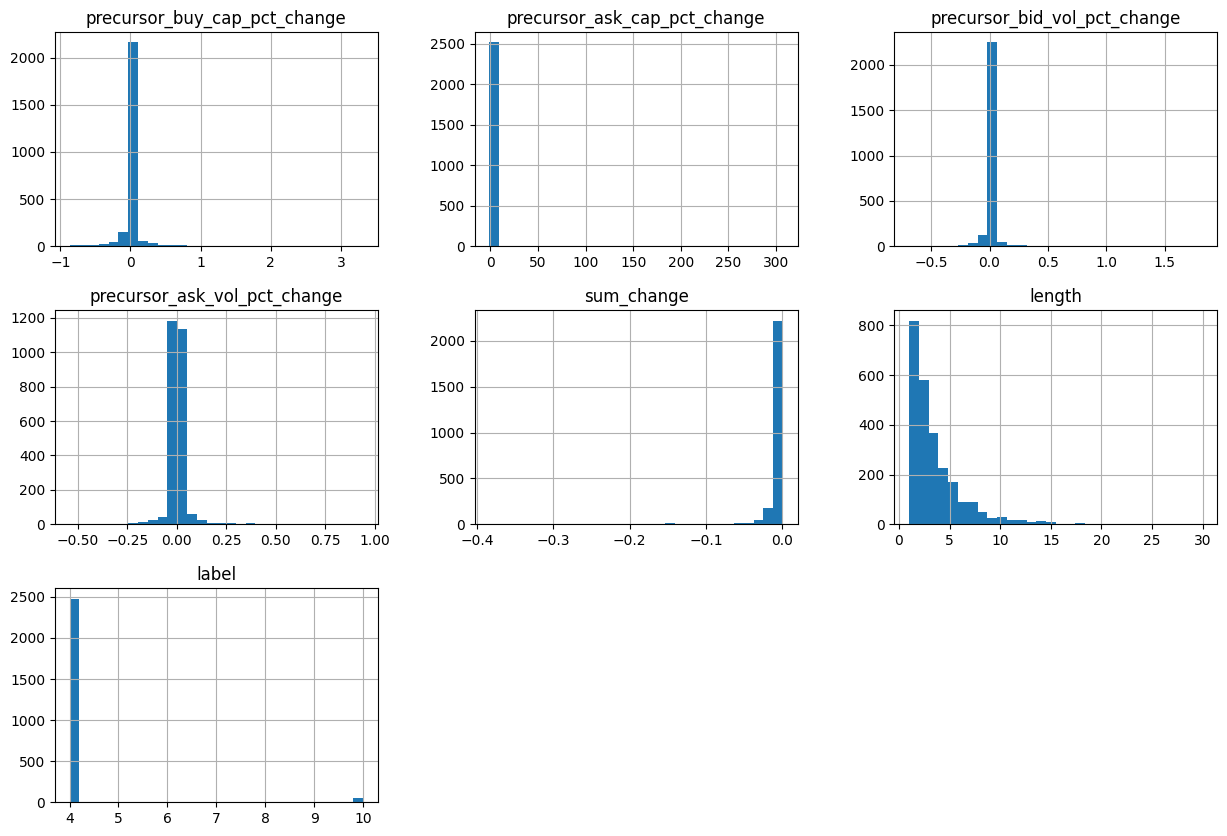

In [24]:
# Select rows with label equal to 4 or 10
rows = subset[(subset['label'] == 4) | (subset['label'] == 10)]

# Create histograms for all columns in the selected rows
rows.hist(bins=30, figsize=(15, 10))

# Show the histograms
plt.show()

In [25]:
subset[(subset['label'] == 4)]['sum_change'].mean()

-0.008453832723064823

In [26]:
subset[(subset['label'] == 10)]['sum_change'].mean()

-0.03706188073835746

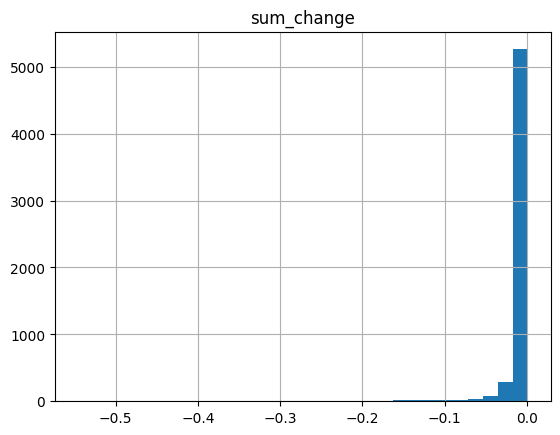

In [27]:
# Create a histogram for the 'sum_change' column
subset.hist(column='sum_change', bins=30)

# Show the histogram
plt.show()

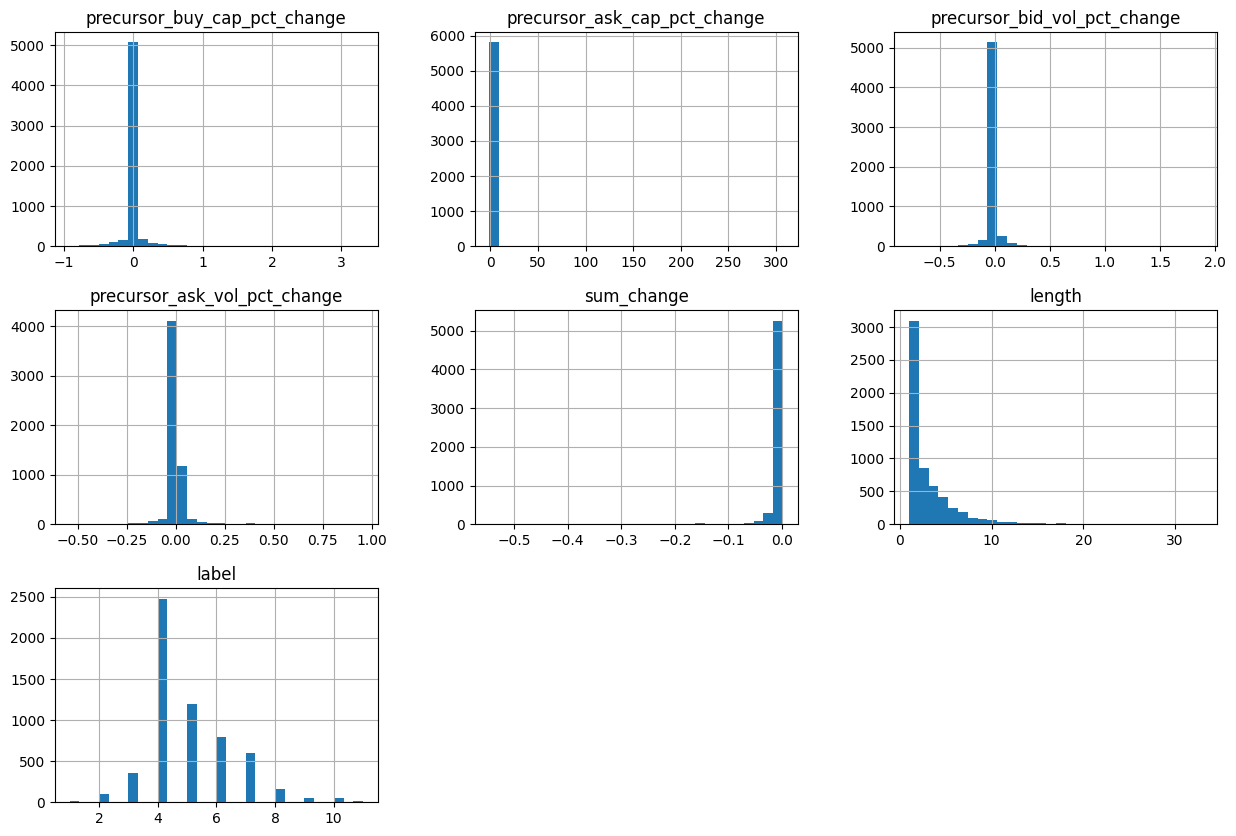

In [28]:
subset.hist(bins=30, figsize=(15, 10))

# Show the histograms
plt.show()

### distribution of features, class 10

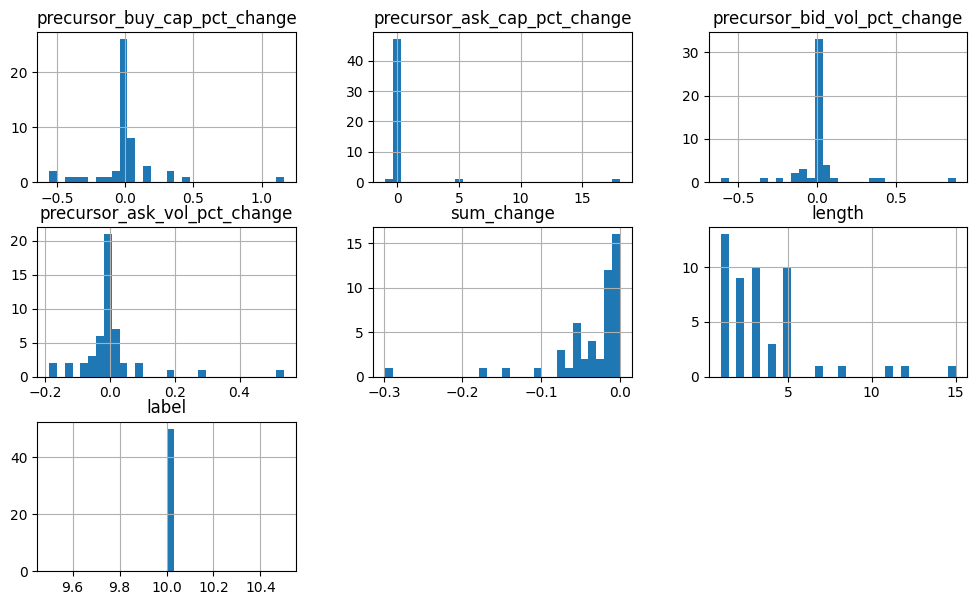

In [29]:
subset[(subset['label'] == 10)].hist(bins=30, figsize=(12, 7))
plt.show()

### feature distribution, class 4

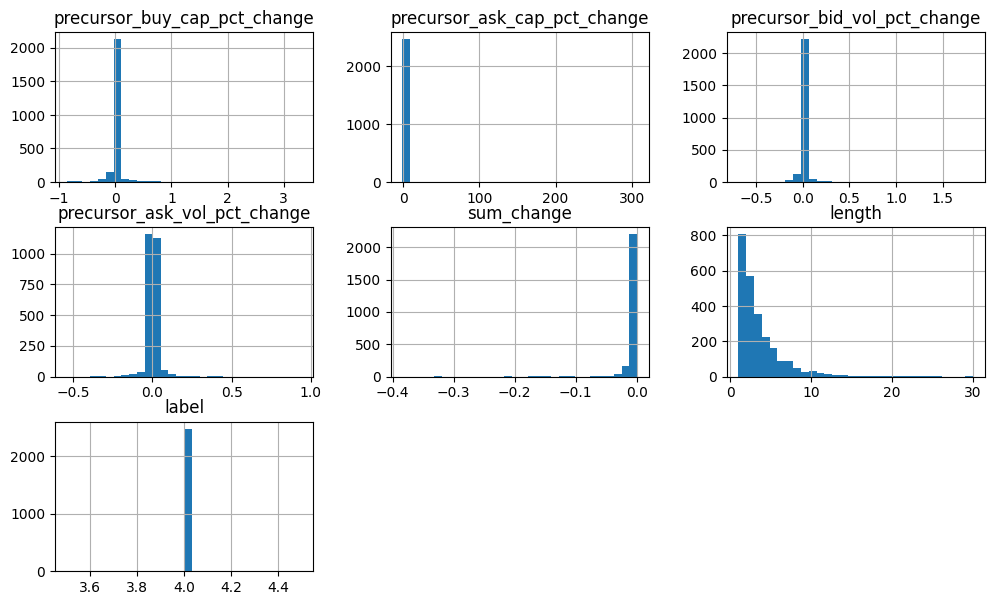

In [30]:
subset[(subset['label'] == 4)].hist(bins=30, figsize=(12, 7))
plt.show()

## Permutation test scoring

[from sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_permutation_tests_for_classification.html#permutation-test-score)

## managing class imbalance

(https://stackoverflow.com/a/55591245)

see next sheet, 5.1


In [ ]:
#save this thing to .pkl format

# import pickle

# with open("model.pkl", "wb") as f:
#     pickle.dump(vc, f)